# Spotify

## Setup

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col,isnan, when, count
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
import pandas as pd
import numpy
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder

In [3]:
spark = SparkSession.builder.appName('abc').getOrCreate()

In [4]:
sdf = spark.read.format("csv").option("header", "true").option(
    "inferSchema", "true").load("./data/Spotify-2000.csv")
sdf.show()

+-----+--------------------+-----------------+--------------------+----+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|Index|               Title|           Artist|           Top Genre|Year|Beats Per Minute (BPM)|Energy|Danceability|Loudness (dB)|Liveness|Valence|Length (Duration)|Acousticness|Speechiness|Popularity|
+-----+--------------------+-----------------+--------------------+----+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|    1|             Sunrise|      Norah Jones|     adult standards|2004|                   157|    30|          53|          -14|      11|     68|              201|          94|          3|        71|
|    2|         Black Night|      Deep Purple|          album rock|2000|                   135|    79|          50|          -11|      17|     81|              207|          17|          7|       

In [5]:
sdf = sdf.drop("Title").drop("Year").drop("Year").drop("Index")
sdf = sdf.withColumn('Length (Duration)',col('Length (Duration)').cast(IntegerType()))

In [6]:
sdf.cache()

DataFrame[Artist: string, Top Genre: string, Beats Per Minute (BPM): int, Energy: int, Danceability: int, Loudness (dB): int, Liveness: int, Valence: int, Length (Duration): int, Acousticness: int, Speechiness: int, Popularity: int]

In [7]:
sdf.is_cached

True

In [8]:
sdf.printSchema()

root
 |-- Artist: string (nullable = true)
 |-- Top Genre: string (nullable = true)
 |-- Beats Per Minute (BPM): integer (nullable = true)
 |-- Energy: integer (nullable = true)
 |-- Danceability: integer (nullable = true)
 |-- Loudness (dB): integer (nullable = true)
 |-- Liveness: integer (nullable = true)
 |-- Valence: integer (nullable = true)
 |-- Length (Duration): integer (nullable = true)
 |-- Acousticness: integer (nullable = true)
 |-- Speechiness: integer (nullable = true)
 |-- Popularity: integer (nullable = true)



## Data exploration

In [9]:
sdf = sdf.na.drop()

In [10]:
sdf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in sdf.columns]).show()

+------+---------+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|Artist|Top Genre|Beats Per Minute (BPM)|Energy|Danceability|Loudness (dB)|Liveness|Valence|Length (Duration)|Acousticness|Speechiness|Popularity|
+------+---------+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|     0|        0|                     0|     0|           0|            0|       0|      0|                0|           0|          0|         0|
+------+---------+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+



## Describe

In [11]:
sdf.describe().toPandas()  # # par défaut ttes les col 
sdf.dtypes
col_num = sdf.select([col[0] for col in sdf.dtypes if col[1] != 'string'])
col_num.show()

feature_numeric = ['Beats Per Minute (BPM)', 'Energy', 'Danceability',  'Loudness (dB)', 'Liveness', 'Valence', 'Length (Duration)', 'Acousticness', 'Speechiness']

+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|Beats Per Minute (BPM)|Energy|Danceability|Loudness (dB)|Liveness|Valence|Length (Duration)|Acousticness|Speechiness|Popularity|
+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|                   157|    30|          53|          -14|      11|     68|              201|          94|          3|        71|
|                   135|    79|          50|          -11|      17|     81|              207|          17|          7|        39|
|                   168|    69|          66|           -9|       7|     52|              341|           2|         17|        69|
|                   173|    96|          43|           -4|       3|     37|              269|           0|          4|        76|
|                   106|    82|          58|           -5|      10|     87|              2

In [12]:
sdf.describe().toPandas()  # # par défaut ttes les col 
sdf.dtypes
col_cat = sdf.select([col[0] for col in sdf.dtypes if col[1] == 'string'])
col_cat.show()

+-----------------+--------------------+
|           Artist|           Top Genre|
+-----------------+--------------------+
|      Norah Jones|     adult standards|
|      Deep Purple|          album rock|
|         Gorillaz| alternative hip hop|
|     Foo Fighters|   alternative metal|
|Bruce Springsteen|        classic rock|
|     City To City|alternative pop rock|
|         Maroon 5|                 pop|
|             Muse|         modern rock|
|      The Killers|         modern rock|
|           Eminem|     detroit hip hop|
|    Elvis Presley|     adult standards|
|The White Stripes|    alternative rock|
|          De Dijk|         dutch indie|
|  Ten Years After|          album rock|
|   Arctic Monkeys|         garage rock|
|    Paul de Leeuw|       dutch cabaret|
|         Coldplay|      permanent wave|
|Alanis Morissette|    alternative rock|
|       John Miles|      classic uk pop|
|Justin Timberlake|           dance pop|
+-----------------+--------------------+
only showing top

In [13]:
feature_cat = ["Artist", "Top Genre"]
feature_cat_indexed = [col+'_indexed' for col in feature_cat]

In [14]:
labelCol = 'Popularity'

In [15]:
feature_cat_encoded = [col +'_encoded' for col in feature_cat_indexed]

## StringIndexer

In [16]:
indexer_feature = StringIndexer(inputCols=feature_cat, handleInvalid='skip', outputCols=feature_cat_indexed)
indexer_label = StringIndexer(inputCol=labelCol, handleInvalid='skip', outputCol=labelCol+'_indexed')
#sdf = indexer_feature.fit(sdf).transform(sdf)

## OneHotEncoder

In [17]:
sdf.show()

+-----------------+--------------------+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|           Artist|           Top Genre|Beats Per Minute (BPM)|Energy|Danceability|Loudness (dB)|Liveness|Valence|Length (Duration)|Acousticness|Speechiness|Popularity|
+-----------------+--------------------+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|      Norah Jones|     adult standards|                   157|    30|          53|          -14|      11|     68|              201|          94|          3|        71|
|      Deep Purple|          album rock|                   135|    79|          50|          -11|      17|     81|              207|          17|          7|        39|
|         Gorillaz| alternative hip hop|                   168|    69|          66|           -9|       7|     52|              341|           2|         1

In [18]:
encoders = OneHotEncoder(dropLast=False, inputCols=feature_cat_indexed, outputCols=feature_cat_encoded)  # handleInvalid='skip',  
#sdf = encoders.fit(sdf).transform(sdf)
#sdf.select(feature_cat_indexed+feature_cat_encoded).show(n=2, truncate=False, vertical=True)

## VectorAssembler

In [19]:
# Vectorizing encoded values
# assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders],outputCol="rawFeatures")

assembler = VectorAssembler(inputCols=feature_cat_encoded+feature_numeric, outputCol='features')

#assembler.transform(sdf).select(feature_cat+feature_numeric+feature_cat_encoded+['features']).show(n=2, truncate=False, vertical=True)

### Pipeline

In [20]:
#Pipeline(stages= [indexer_feature]+[indexer_label]+[encoders]+[assembler]).fit(sdf).transform(sdf).show(n=1, truncate=False, vertical=True)

In [21]:
sdf.printSchema()

root
 |-- Artist: string (nullable = true)
 |-- Top Genre: string (nullable = true)
 |-- Beats Per Minute (BPM): integer (nullable = true)
 |-- Energy: integer (nullable = true)
 |-- Danceability: integer (nullable = true)
 |-- Loudness (dB): integer (nullable = true)
 |-- Liveness: integer (nullable = true)
 |-- Valence: integer (nullable = true)
 |-- Length (Duration): integer (nullable = true)
 |-- Acousticness: integer (nullable = true)
 |-- Speechiness: integer (nullable = true)
 |-- Popularity: integer (nullable = true)



In [22]:
train, test = sdf.randomSplit([0.7, 0.3],seed = 11)
train.show(n=1, truncate=False, vertical=True)
test.show(n=1, truncate=False, vertical=True)

-RECORD 0----------------------------
 Artist                 | 10cc       
 Top Genre              | album rock 
 Beats Per Minute (BPM) | 98         
 Energy                 | 50         
 Danceability           | 52         
 Loudness (dB)          | -11        
 Liveness               | 11         
 Valence                | 66         
 Length (Duration)      | 242        
 Acousticness           | 16         
 Speechiness            | 3          
 Popularity             | 46         
only showing top 1 row

-RECORD 0------------------------
 Artist                 | 2Pac   
 Top Genre              | g funk 
 Beats Per Minute (BPM) | 111    
 Energy                 | 66     
 Danceability           | 87     
 Loudness (dB)          | -7     
 Liveness               | 14     
 Valence                | 32     
 Length (Duration)      | 269    
 Acousticness           | 4      
 Speechiness            | 8      
 Popularity             | 72     
only showing top 1 row



In [23]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(labelCol='Popularity_indexed', featuresCol='features')

train, test = sdf.randomSplit([0.7, 0.3], seed = 11)

train.cache()
test.cache()
train.show()

model = Pipeline(stages= [indexer_feature]+[indexer_label]+[encoders]+[assembler] + [lr]).fit(train)
pred_lr = model.transform(test)
pred_lr.select('prediction', 'Popularity_indexed', 'features').show()
pred_lr.show(n=1, vertical=True, truncate=False)

+-------------------+-----------------+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|             Artist|        Top Genre|Beats Per Minute (BPM)|Energy|Danceability|Loudness (dB)|Liveness|Valence|Length (Duration)|Acousticness|Speechiness|Popularity|
+-------------------+-----------------+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|               10cc|       album rock|                    98|    50|          52|          -11|      11|     66|              242|          16|          3|        46|
|               10cc|       album rock|                   105|    38|          84|          -13|      20|     89|              268|          54|          6|        67|
|               10cc|       album rock|                   134|    52|          40|          -16|      28|     16|              367|          69|          6|    

In [24]:
print(model.stages[-1].summary.meanAbsoluteError)


6.946111195167622


## Scatter plot

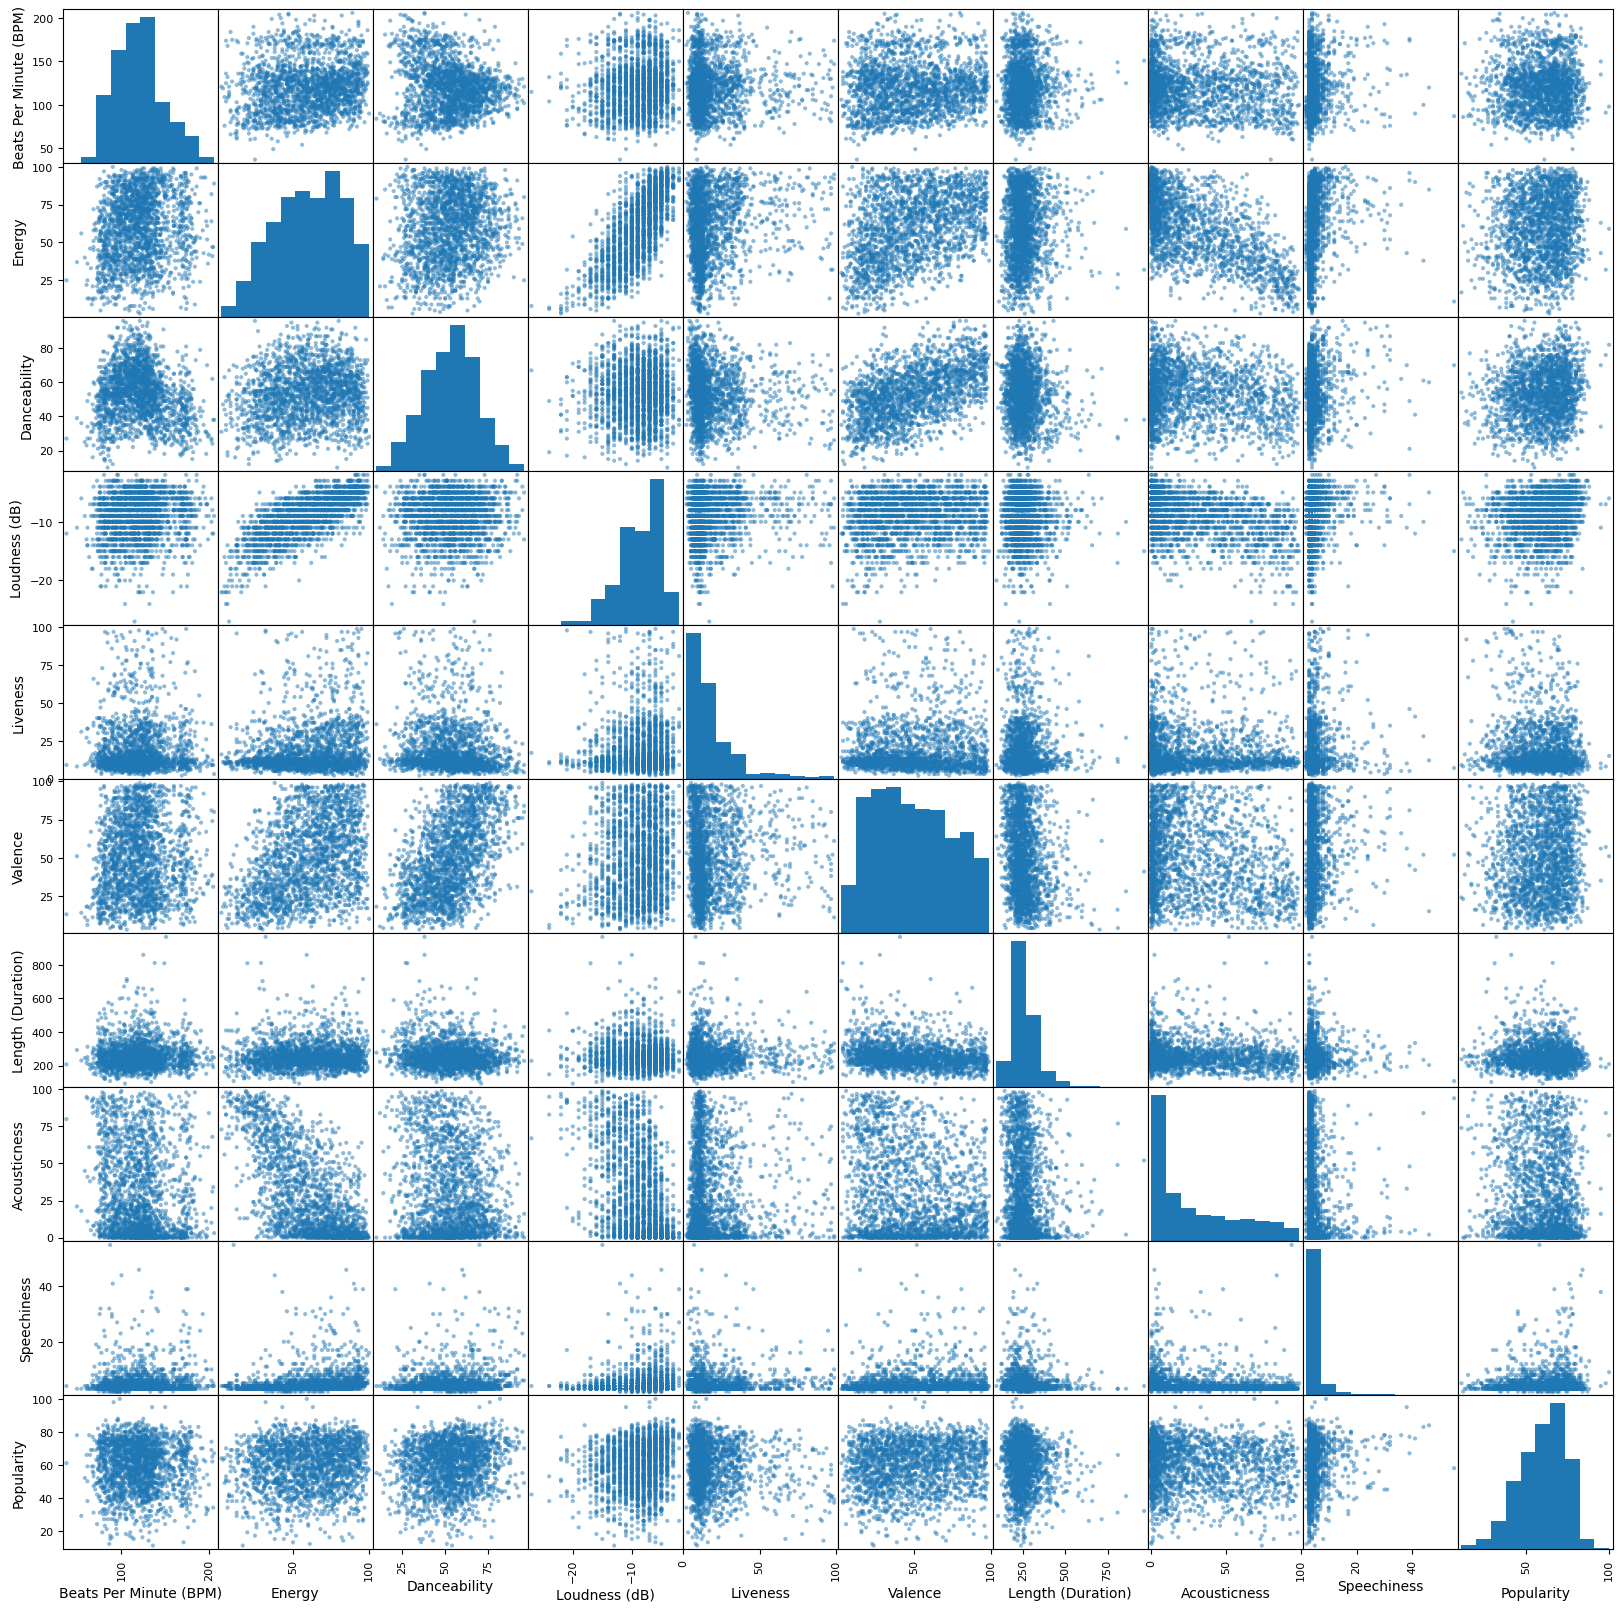

In [25]:
from pandas.plotting import scatter_matrix

pandasSdf = sdf.toPandas()
scatterMatrix = scatter_matrix(pandasSdf,figsize=(20,20))

# Notre target est la colonne "Popularity"
# Nous avons choisi de l'utiliser en temps qu'axe Y pour étudier l'impact des autres colonnes sur la "Popularity"


In [26]:
from pyspark.ml.regression import RandomForestRegressor

train, test = sdf.randomSplit([0.7, 0.3], seed = 11)

rf= RandomForestRegressor(labelCol='Popularity_indexed', featuresCol='features')

In [27]:
model = Pipeline(stages= [indexer_feature]+[indexer_label]+[encoders]+[assembler] + [rf]).fit(train)

In [28]:
pred_rf = model.transform(test)
pred_rf.select('prediction', 'Popularity_indexed', 'features').show()
pred_rf.show(n=1, vertical=True, truncate=False)

+------------------+------------------+--------------------+
|        prediction|Popularity_indexed|            features|
+------------------+------------------+--------------------+
|19.757087696319484|              14.0|(715,[143,647,706...|
|19.329508853469083|              19.0|(715,[251,589,706...|
|19.164312889974383|              37.0|(715,[9,601,706,7...|
|19.164312889974383|               7.0|(715,[9,601,706,7...|
|19.757087696319484|              26.0|(715,[9,601,706,7...|
|19.329508853469083|              29.0|(715,[9,601,706,7...|
|19.329508853469083|               9.0|(715,[9,601,706,7...|
|19.329508853469083|               4.0|(715,[9,601,706,7...|
|19.329508853469083|              24.0|(715,[9,601,706,7...|
|19.591891732824784|              32.0|(715,[9,601,706,7...|
|19.055657144278594|              39.0|(715,[9,601,706,7...|
|19.188778347844266|              28.0|(715,[9,601,706,7...|
|19.623966492753816|              60.0|(715,[94,583,706,...|
|19.095425047575826|    

In [29]:
model.stages[-1].trees

[DecisionTreeRegressionModel: uid=dtr_7cb7d868bde4, depth=5, numNodes=47, numFeatures=715,
 DecisionTreeRegressionModel: uid=dtr_43dfd3a08777, depth=5, numNodes=39, numFeatures=715,
 DecisionTreeRegressionModel: uid=dtr_e8dc5ce67312, depth=5, numNodes=19, numFeatures=715,
 DecisionTreeRegressionModel: uid=dtr_43d7dd59af29, depth=5, numNodes=31, numFeatures=715,
 DecisionTreeRegressionModel: uid=dtr_60465bc89c68, depth=5, numNodes=39, numFeatures=715,
 DecisionTreeRegressionModel: uid=dtr_4ad08d27e52d, depth=5, numNodes=37, numFeatures=715,
 DecisionTreeRegressionModel: uid=dtr_f056bc892377, depth=5, numNodes=31, numFeatures=715,
 DecisionTreeRegressionModel: uid=dtr_b2e2c80bc213, depth=5, numNodes=39, numFeatures=715,
 DecisionTreeRegressionModel: uid=dtr_5ceb344c5113, depth=5, numNodes=27, numFeatures=715,
 DecisionTreeRegressionModel: uid=dtr_f769b2e5c2e8, depth=5, numNodes=21, numFeatures=715,
 DecisionTreeRegressionModel: uid=dtr_2aa096e96d65, depth=5, numNodes=41, numFeatures=715,

In [30]:
from pyspark.ml.evaluation import RegressionEvaluator

In [31]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="Popularity_indexed", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(pred_rf)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

rfModel = model.stages[-1]
print(rfModel)  # summary only

Root Mean Squared Error (RMSE) on test data = 15.4914
RandomForestRegressionModel: uid=RandomForestRegressor_7933a24458ec, numTrees=20, numFeatures=715


In [32]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [33]:
ExtractFeatureImp(model.stages[-1].featureImportances, pred_rf, "features").head(10)

idx                                       name     score
597  588      Top Genre_indexed_encoded_dutch indie  0.300678
26    17               Artist_indexed_encoded_Anouk  0.072491
31    22  Artist_indexed_encoded_Boudewijn de Groot  0.059574
440  431            Artist_indexed_encoded_Maroon 5  0.036410
4    710                                   Liveness  0.034234
2    708                               Danceability  0.030541
29    20         Artist_indexed_encoded_Andre Hazes  0.027282
596  587        Top Genre_indexed_encoded_dutch pop  0.025347
0    706                     Beats Per Minute (BPM)  0.024199
5    711                                    Valence  0.023332

In [34]:
from pyspark.ml.feature import PCA
pca = PCA(k=2, inputCol="features")
pca.setOutputCol("pca_features")

pcaModel = pca.fit(pred_lr)

In [35]:
print("====Eigenvector====")
print(pcaModel.pc)

print("====Contribution rate====")
print(pcaModel.explainedVariance)

====Eigenvector====
DenseMatrix([[-6.03018825e-05,  6.69022784e-05],
             [-3.43291216e-04, -5.04636063e-04],
             [ 2.17794454e-05, -2.56929117e-04],
             ...,
             [ 9.94818002e-01,  7.05119864e-03],
             [-3.68374624e-02, -7.02864788e-01],
             [-8.44151912e-04,  2.41501909e-02]])
====Contribution rate====
[0.702479151091898,0.12061152698030042]


In [36]:
shape = sdf.select(feature_numeric).toPandas().shape

In [37]:
from sklearn.decomposition import PCA

In [38]:
pca = PCA()
quantity = sdf.select(feature_numeric).toPandas()
pca.fit(quantity)
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(1009)], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : numpy.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : numpy.round(numpy.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
eig

plt.figure(figsize = (15, 12)) # modifie la taille du graphique
seaborn.barplot(data = eig, x = "Dimension", y = "% variance expliquée")
plt.text(5, 18, "17%")
plt.axhline(y = 17, linewidth = .5, color = "dimgray", linestyle = "--") # ligne 17 = 100 / 6 (nb dimensions)
plt.show() # cette ligne supprime l'affichage inutile en amont du graphique

[6.63988201e+03 1.30891798e+03 7.67345827e+02 5.27788119e+02
 3.00692965e+02 1.77124823e+02 1.31033021e+02 1.80203446e+01
 5.36448991e+00]
[6.72313487e-01 1.32532960e-01 7.76967042e-02 5.34405688e-02
 3.04463145e-02 1.79345668e-02 1.32675953e-02 1.82462892e-03
 5.43175151e-04]


ValueError: All arrays must be of the same length

In [39]:
n = quantity.shape[0] # nb individus
p = quantity.shape[1] # nb variables
eigval = (n-1) / n * pca.explained_variance_ # valeurs propres
sqrt_eigval = numpy.sqrt(eigval) # racine carrée des valeurs propres
corvar = numpy.zeros((p,p)) # matrice vide pour avoir les coordonnées
for k in range(p):
    corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]
# on modifie pour avoir un dataframe
coordvar = pd.DataFrame({'id': quantity.columns, 'COR_1': corvar[:,0], 'COR_2': corvar[:,1]})


# Création d'une figure vide (avec des axes entre -1 et 1 + le titre)
fig, axes = plt.subplots(figsize = (10, 10))
fig.suptitle("Cercle des corrélations")
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)
# Ajout des axes
axes.axvline(x = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
axes.axhline(y = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
# Ajout des noms des variables
for j in range(p):
    axes.text(coordvar["COR_1"][j],coordvar["COR_2"][j], coordvar["id"][j])
# Ajout du cercle
plt.gca().add_artist(plt.Circle((0,0),1,color='blue',fill=False))
plt.show()